## Import some pkgs

In [1]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
from collections import defaultdict as ddict

In [2]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch
from utils.measures import geodesic_dist, reg_R_fn, lin_R_fn

plt.style.use(FIG_ROOT/"base.mplstyle")

## Some fns

In [4]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

<function __main__.<lambda>(x)>

In [5]:
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

### Some parameters

In [6]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta = [13, 20]
_paras.beta_l = [13, 20]
_paras.beta_h = [15, 25]
_paras.cols = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",]
_paras.markers = ["o", "h", "*", "+"]
_paras.xaxis_labs = [r"$\delta$", r"$\theta$", r"$\alpha$", r"$\beta$"]
_paras.barh = 0.05

In [7]:
# Parameter bounds for optimization
v_lower = 3.5-1.8
v_upper = 3.5+1.8
bnds = ((0.005,0.030), (v_lower,v_upper), (0.1,1.0))
#tauG,speed,alpha

((0.005, 0.03), (1.7, 5.3), (0.1, 1.0))

In [14]:
paras = edict()

paras.fc_type = "alpha"
paras.epoch = ""
paras.freqrange =  np.linspace(_paras[paras.fc_type][0], _paras[paras.fc_type][1], 5) 
print(paras.freqrange)
paras.fs = 600
paras.par_low =  np.array([ix[0] for ix in bnds])
paras.par_high = np.array([ix[1] for ix in bnds])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10
paras.add_v = 0.05

paras.cmp_names = [
    "no diagws", 
    "no diagws 82ROIs", 
    "diagws log", 
    "diagws 1w1",
    "diagws 1w1 82ROIs",
    "diagws 1w1 minmax",
]

paras.fil_names = [
    (f"newsgmws1_posteriorMRmul_"+
         f"alpha_num1000_densitynsf_MR3_noise_sd80_addv5"), 
    (f"newsgmws1-82ROIs_posteriorMRmul_"+
         f"alpha_num1000_densitynsf_MR3_noise_sd80_addv1"), 
    (f"newsgmlogmin_posteriorMRmul_"+
         f"alpha_num1000_densitynsf_MR3_noise_sd80_addv5"), 
    (f"newsgm1w1_posteriorMRmul_"+
         f"alpha_num1000_densitynsf_MR3_noise_sd80_addv5"), 
    (f"newsgm1w1-82ROIs_posteriorMRmul_"+
         f"alpha_num1000_densitynsf_MR3_noise_sd80_addv1"), 
    (f"newsgm1w1minmax_posteriorMRmul_"+
         f"alpha_num1000_densitynsf_MR3_noise_sd80_addv5"), 
]


[ 8.  9. 10. 11. 12.]


In [9]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

functools.partial(<function theta_raw_2out at 0x7f92be400790>, map_fn=functools.partial(<function logistic_np at 0x7f92be400700>, k=0.1))

In [12]:
# Load true MEG FC time series:
dataPath = DATA_ROOT/f'./MEG_FC_{paras.fc_type}_DK_networks_coh.mat'
data = loadmat(dataPath);
true_FC = data[f"MEG_{paras.fc_type}_FC_networks_coh"]
true_FC.shape

(68, 68, 36)

In [20]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;

In [26]:
 true_FC[:, :, sub_idx].shape

(68, 68)

In [29]:
scs[:, :, sub_idx].shape

(68, 68)

In [57]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr

In [70]:
def cal_metrics1(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    fc1_c = _minmax_vec(fc1[np.triu_indices(size_fc, k=1)])
    fc2_c = _minmax_vec(fc2[np.triu_indices(size_fc, k=1)])
    
    tau = kendalltau(fc1_c, fc2_c)[0]
    sp_r = spearmanr(fc1_c, fc2_c)[0]
    
    res = edict()
    res.tau = tau
    res.sp_r = sp_r
    return res

In [78]:
scs = ind_conn[:, :];
sub_idx = 0
ress = []
for sub_idx  in range(36):
    cur_sc = scs[:, :, sub_idx]
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  cur_sc # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    
    res = cal_metrics1(brain.reducedConnectome[:68, :68], true_FC[:, :, sub_idx])
    ress.append(res)

In [79]:
np.mean([res["tau"] for res in ress])

0.21773488203301808

In [80]:
np.mean([res["sp_r"] for res in ress])

0.3195657532948341

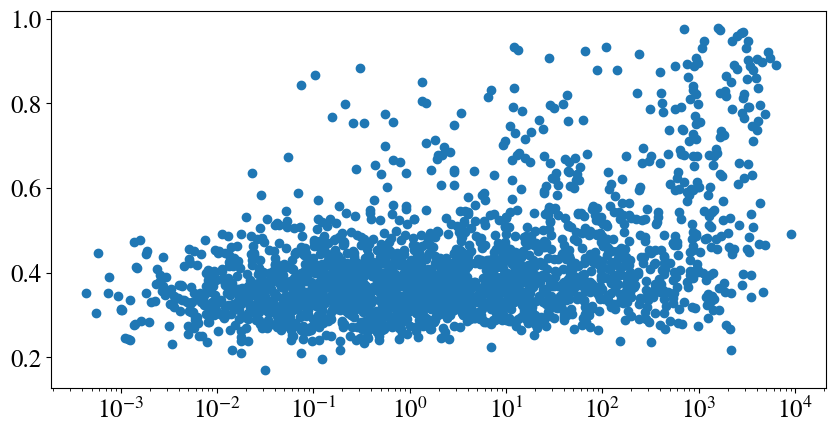

In [64]:
sub_idx = 9
cur_sc = scs[:, :, sub_idx]
cur_fc = true_FC[:, :, sub_idx]
vec1 = cur_sc[np.triu_indices(68, k=1)]
vec2 = cur_fc[np.triu_indices(68, k=1)]
plt.figure(figsize=[10, 5])
#plt.title(f"Corr {ress[sub_idx]['reg_r']:.3f}")
plt.plot(vec1, vec2, "o")
plt.xscale("log")

In [35]:
np.mean([res["reg_r"] for res in ress]), np.mean([res["reg_r"] for res in ress])

0.404813719577398

## Calculate the metrics

linR, pearsons R and geodesic dist

In [65]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr

def divideFc(fc):
    """Divide the FC into three blocks and vector them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _minmax_vec(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _minmax_vec(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _minmax_vec(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    # for geodedic
    fc1_g = fc1/np.linalg.norm(fc1) + np.eye(size_fc)
    fc2_g = fc2/np.linalg.norm(fc2) + np.eye(size_fc)
    
    fc1_c = _minmax_vec(fc1[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    fc2_c = _minmax_vec(fc2[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    
    # all metrics
    geo_dist = geodesic_dist(fc1_g, fc2_g)
    reg_r = reg_R_fn(fc1_c, fc2_c)
    lin_r = lin_R_fn(fc1_c, fc2_c)
    tau_r = kendalltau(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    sp_r = spearmanr(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    
    # block wise metrics
    blocks1 = divideFc(fc1)
    blocks2 = divideFc(fc2)
    reg_r_block = [reg_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    lin_r_block = [lin_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    
    res = edict()
    res.geo_dist = geo_dist
    res.reg_r = reg_r[0]
    res.lin_r = lin_r[0]
    res.tau_r = tau_r
    res.sp_r = sp_r 
    res.reg_r_block = np.mean(reg_r_block)
    res.lin_r_block = np.mean(lin_r_block)
    return res

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = ddict(list)
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        for key, v in res.items():
            ress[key].append(v)
    
    return ress

In [66]:
fcs_true = true_FC.transpose(2, 0, 1) 

ress = []
for fil_name in paras.fil_names:
    print(fil_name)
    cur_p = RES_ROOT/fil_name/"inf_res_fb.pkl"
    cur_res = load_pkl(cur_p, verbose=False);
    cur_fcs_est = np.array(cur_res.est_FCs)
    ress.append(cal_metrics_batch(fcs_true, cur_fcs_est))

newsgmws1_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd80_addv5
newsgmws1-82ROIs_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd80_addv1
newsgmlogmin_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd80_addv5
newsgm1w1_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd80_addv5
newsgm1w1-82ROIs_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd80_addv1
newsgm1w1minmax_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd80_addv5


In [68]:
import pandas as pd
data = []
key_names = ['geo_dist', 'reg_r', 'tau_r', 'sp_r', 'lin_r']
for ix in range(len(paras.cmp_names)):
    for key in key_names:
        for value in ress[ix][key]:
            data.append({'Group': paras.cmp_names[ix], 'Key': key, 'Value': value})
df = pd.DataFrame(data);


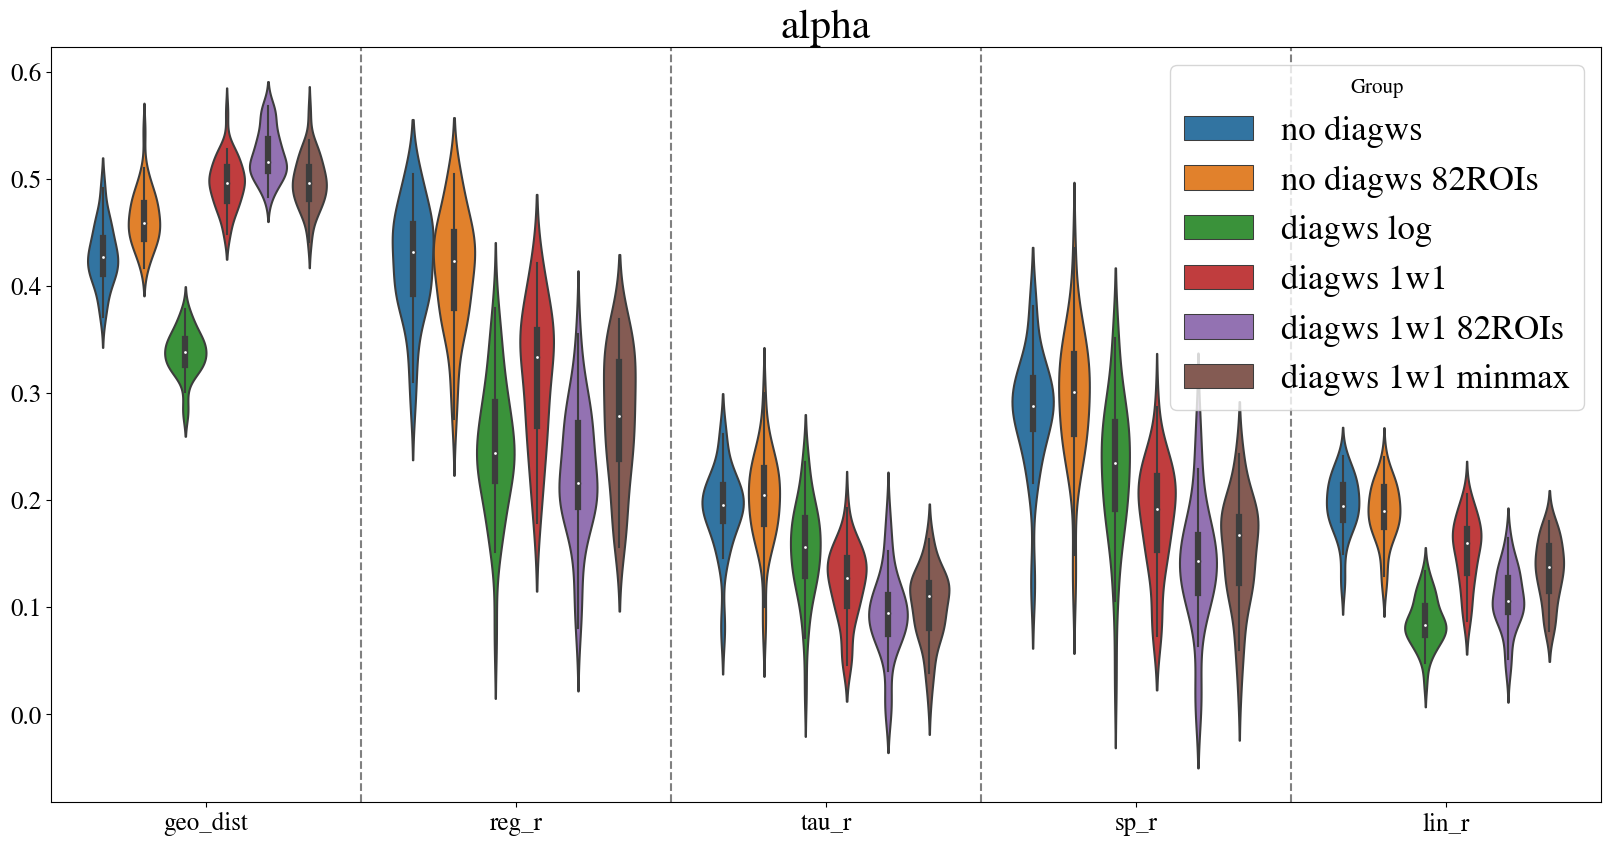

In [69]:
plt.figure(figsize=[20, 10])
plt.title(f"alpha", fontsize=30)
ax = sns.violinplot(x='Key', y='Value', hue='Group', data=df, split=False)
plt.xlabel("")
plt.ylabel("")

keys = df['Key'].unique()
for key_idx, key in enumerate(keys):
    if key_idx < len(keys) - 1:
        ax.axvline(x=key_idx + 0.5, color='grey', linestyle='--')
        
#plt.savefig(FIG_ROOT/f"{typ}_cmp.jpg")